# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [2]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [3]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores al rango [0,1]) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [8]:
# 2.1)
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

# download the MNIST dataset
train_dataset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)


100%|██████████| 26.4M/26.4M [00:05<00:00, 4.62MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 113kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 2.16MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.0MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



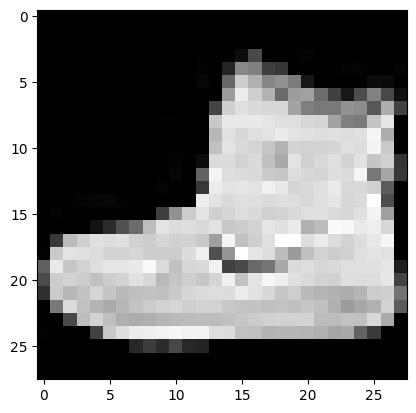

In [10]:
# 2.2)
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

In [11]:
# 2.3)
labels_names = {
    0: 'T-shirt/top', #remera manga corta
    1: 'Trouser', #pantalon
    2: 'Pullover', 
    3: 'Dress', #vestido
    4: 'Coat', #abrigo
    5: 'Sandal', #sandalia
    6: 'Shirt', #camisa
    7: 'Sneaker', #zapatilla
    8: 'Bag', #bolso
    9: 'Ankle boot' #bota
}

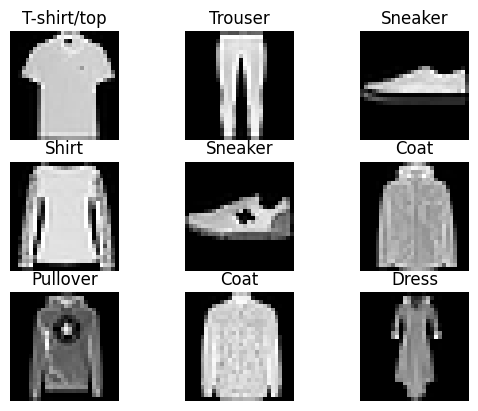

In [14]:
# 2.4)

figure = plt.figure()
cols, rows = 3, 3
for i in range (1, cols*rows+1):
    j = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[j]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_names[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [17]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
len(train_loader.dataset) # numero de ejemplos

60000

In [19]:
len(train_loader) # numero de batches

600

In [20]:
# 3.2)
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(type(images), images.shape)
print(type(labels), labels.shape)

<class 'torch.Tensor'> torch.Size([100, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([100])


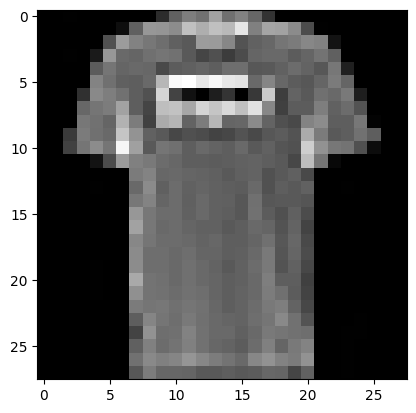

In [26]:
# miramos una imagen
plt.imshow(images[3].squeeze(), cmap='gray')

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [27]:
# 4)
class NeuralNetwork(nn.Module):
    def __init__(self, n1, n2, p=0.2):
        super(NeuralNetwork, self).__init__()
        # capa 0
        self.flatten = nn.Flatten() # capa Flatten
        # capa 1
        self.fc1 = nn.Linear(28*28, n1) # capa Fully Connected
        self.relu = nn.ReLU() # capa ReLU
        self.dropout = nn.Dropout(p) # capa Dropout
        # capa 2
        self.fc2 = nn.Linear(n1, n2) # capa Fully Connected
        self.relu = nn.ReLU() # capa ReLU
        self.dropout = nn.Dropout(p) # capa Dropout
        # capa 3
        self.fc3 = nn.Linear(n2, 10) # capa Fully Connected
    def forward(self, x):
        # capa 0
        x = self.flatten(x)
        # capa 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # capa 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        # capa 3
        x = self.fc3(x)
        return x

In [28]:
my_nn = NeuralNetwork(128, 64)
my_nn(images).shape

torch.Size([100, 10])

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [ ]:
# 5.1)

# Definimos la funcion de entrenamiento
def train_loop(data_loader, model, loss_fn, optimizer):
    # activamos la maquina de entrenamiento
    model.train()
    # definimos constantes
    num_samples = len(data_loader.dataset)
    num_batches = len(data_loader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_precessed_samples = 0
    # loop de entrenamiento
    for batch, (X, y) in enumerate(data_loader):
        # copiamos las entradas y las salidas al dispositivo de trabajo
        X, y = X.to(device), y.to(device)
        batch_size = len(X) # tamaño del batch
        # Calculamos la prediccion del modelo y lo correspondiente funcion de perdida
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropagation usamos el optimozador
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        # calculamos el numero de predicciones correctas en el batch y lo agregamos a una suma correspondiente
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # calculamos el numero de ejemplos procesados
        num_precessed_samples += batch_size
        # imprimimos el progreso
        if batch % max(num_batches // 10, 1) == 0:
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
                  f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

In [ ]:
# 5.2)
def valid_model(dataloader, model, loss_fn):
    # desactivamos la maquina de entrenamiento
    model.eval()

    # definimos constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    # para testear, desactivamos el calculo de gradientes
    with torch.no_grad():
        # iteramos sobre los batches
        for X, y in dataloader:
            # copiamos las entradas y las salidas al dispositivo de trabajo
            X, y = X.to(device), y.to(device)
            batch_size = len(X) # tamaño del batch
            num_processed_samples += batch_size
            # Calculamos la prediccion del modelo y lo correspondiente funcion de perdida
            pred = model(X)
            loss = loss_fn(pred, y)
            # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss
            # calculamos el numero de predicciones correctas en el batch y lo agregamos a una suma correspondiente
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # calculamos el numero de ejemplos procesados
            num_precessed_samples += batch_size
    # calculamos la perdida promedio y la precision
    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Loss: {avg_loss:.6f} | Precision: {precision:.2f}')
    return avg_loss, precision

In [ ]:
# 5.3)
# Creamos los dataLoaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 5.4)
# creamos una instancia de una funcion de perdida,cross entropy
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# 5.5)
n1, n2 = 128, 64
p = 0.2
my_nn = NeuralNetwork(n1, n2, p)

In [ ]:
# 5.6)
# creamos un optimizador, un Srocastic Gradient Descent
learning_rate = 1e-3
optimizer = torch.optim.Adam(my_nn.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False)

In [ ]:
# 5.7)
# determinamos en que dispositivo vamos a trabajar
device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_nn.to(device)

In [ ]:
# 5.8) y 5.9)
num_epochs = 30
list_train_avg_loss_incorrect = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrect = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    train_avg_loss_incorrect, train_precision_incorrect = train_loop(train_loader, my_nn, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_loop(train_loader, my_nn, loss_fn)
    valid_avg_loss, valid_precision = valid_loop(test_loader, my_nn, loss_fn)
    list_train_avg_loss_incorrect.append(train_avg_loss_incorrect)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrect.append(train_precision_incorrect)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('Finished Training')